In [2]:
import os,sys
import cv2
from tqdm import tqdm
import re
import random

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical


from tensorflow.keras import models, Sequential, layers, regularizers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import image_dataset_from_directory 
import tensorflow.keras.applications.resnet50 as resnet50

In [4]:
path_train = '/kaggle/input/stanford-dogs-dataset-traintest/cropped/train'
path_test = '/kaggle/input/stanford-dogs-dataset-traintest/cropped/test'

# Functions

In [5]:
# Function for plotting the loss and accuracy 
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

In [13]:
# Function for plotting + comparing 2 models
def plot_compare_history(history, name_history, history_1, name_history_1):
    
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    
    ax[0].set_title('loss')
    
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss " + name_history)
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss " + name_history)
    
    ax[0].plot(history_1.epoch, history_1.history["loss"], label="Train loss " + name_history_1)
    ax[0].plot(history_1.epoch, history_1.history["val_loss"], label="Validation loss " + name_history_1)
    
    ax[1].set_title('Accuracy')
    
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train Accuracy " + name_history)
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Accuracy " + name_history)
    
    ax[1].plot(history_1.epoch, history_1.history["accuracy"], label="Train Accuracy " + name_history_1)
    ax[1].plot(history_1.epoch, history_1.history["val_accuracy"], label="Validation Accuracy " + name_history_1)
    
    ax[0].legend()
    ax[1].legend()

# X and y

In [6]:
# Preprocess the input images using the ResNet50 preprocess_input function
def preprocess(img, label):
    img = resnet50.preprocess_input(img)
    return img, label

In [7]:
# TRAIN DATASET
train_dataset = image_dataset_from_directory(directory=path_train,
                                      labels='inferred',
                                      label_mode="categorical",
                                      validation_split=0.2,
                                      subset="training",
                                      seed=123,
                                      image_size=(224, 224),
                                      batch_size=32)   

# Preprocess X in the train_dataset
train_ds_prepro = train_dataset.map(preprocess)

###########
# VALIDATION DATASET
val_dataset = image_dataset_from_directory(directory=path_train,
                                      labels='inferred',
                                      label_mode="categorical",
                                      validation_split=0.2,
                                      subset="validation",
                                      seed=123,
                                      image_size=(224, 224),
                                      batch_size=32)
                                         
# Preprocess X in the val_dataset
validation_ds_prepro = val_dataset.map(preprocess)

############
# TEST DATASET
test_dataset = image_dataset_from_directory(directory=path_test,
                                            labels='inferred',
                                            label_mode="categorical",
                                            validation_split=None,
                                            subset=None,
                                            seed=123,
                                            image_size=(224, 224),
                                            batch_size=32) 

# Preprocess X in the test_dataset
test_ds_prepro = test_dataset.map(preprocess)

Found 12000 files belonging to 120 classes.
Using 9600 files for training.
Found 12000 files belonging to 120 classes.
Using 2400 files for validation.
Found 8580 files belonging to 120 classes.


In [9]:
# Check the preprocessed X in the train_dataset
image_batch_train, labels_batch_train = next(iter(train_ds_prepro))
first_image_train = image_batch_train[0]
first_image_train
print("from the train dataset")
print(image_batch_train.shape)
print(np.min(first_image_train), np.max(first_image_train))

# Check the preprocessed X in the val_dataset
image_batch_val, labels_batch_val = next(iter(validation_ds_prepro))
first_image_val = image_batch_val[0]
first_image_val
print("from the val dataset")
print(image_batch_val.shape)
print(np.min(first_image_val), np.max(first_image_val))

# Check the preprocessed X in the test_dataset
image_batch_test, labels_batch_test = next(iter(test_ds_prepro))
first_image_test = image_batch_test[0]
first_image_test
print("from the test dataset")
print(image_batch_test.shape)
print(np.min(first_image_test), np.max(first_image_test))

from the train dataset
(32, 224, 224, 3)
-123.68 148.061
from the val dataset
(32, 224, 224, 3)
-123.68 127.32
from the test dataset
(32, 224, 224, 3)
-107.68 151.061


# BASE MODEL = ResNet50

In [11]:
# BASE MODEL 
# Load the ResNet50 model pre-trained on ImageNet
base_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Freeze the base model layers to prevent them from being updated during training
base_model.trainable = False

94765736/94765736 [==============================] - 1s 0us/step


# MODEL 1 (Jihed's model)

In [12]:
# Add a new classification head on top of the pre-trained ResNet50 base model
model_1 = Sequential([
    layers.Input((224, 224, 3)),
    layers.RandomFlip(mode='horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Flatten(),                    #flatten the feature map and push it into a Fully Connected Layer which is then used for producing predictions.
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(120, activation='softmax')
])


opt = optimizers.Adam(learning_rate=1e-4)
model_1.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model_1.summary()

In [9]:
# Define EarlyStopping, ModelCheckpoint and ReduceLROnPlateau callbacks
MODEL = "model_1"

es = EarlyStopping(monitor='val_accuracy', 
                   mode='max', 
                   patience=5, 
                   verbose=1, 
                   restore_best_weights=True)

mcp = ModelCheckpoint("{}.h5".format(MODEL),
                      save_weights_only=True,
                      monitor='val_accuracy',
                      mode='max',
                      verbose=0,
                      save_best_only=True)

rlr = ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.1, 
                        patience=2, 
                        verbose=0)


# Train the model using the preprocessed training dataset and validate using the validation dataset
history_1 = model_1.fit(train_ds_prepro, 
                    validation_data=validation_ds_prepro, 
                    epochs=10,
                    batch_size=32,
                    callbacks=[es, mcp, rlr],
                    verbose=1)

Epoch 1/10
300/300 [==============================] - 102s 297ms/step - loss: 4.3593 - accuracy: 0.0823 - val_loss: 3.2177 - val_accuracy: 0.3663 - lr: 1.0000e-04
Epoch 2/10
300/300 [==============================] - 87s 289ms/step - loss: 2.9375 - accuracy: 0.3051 - val_loss: 1.7584 - val_accuracy: 0.6196 - lr: 1.0000e-04
Epoch 3/10
300/300 [==============================] - 87s 288ms/step - loss: 2.1662 - accuracy: 0.4437 - val_loss: 1.2501 - val_accuracy: 0.6992 - lr: 1.0000e-04
Epoch 4/10
300/300 [==============================] - 87s 288ms/step - loss: 1.7863 - accuracy: 0.5216 - val_loss: 1.0026 - val_accuracy: 0.7392 - lr: 1.0000e-04
Epoch 5/10
300/300 [==============================] - 86s 286ms/step - loss: 1.5687 - accuracy: 0.5739 - val_loss: 0.8769 - val_accuracy: 0.7563 - lr: 1.0000e-04
Epoch 6/10
300/300 [==============================] - 88s 292ms/step - loss: 1.4534 - accuracy: 0.5884 - val_loss: 0.7934 - val_accuracy: 0.7783 - lr: 1.0000e-04
Epoch 7/10
300/300 [=======

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

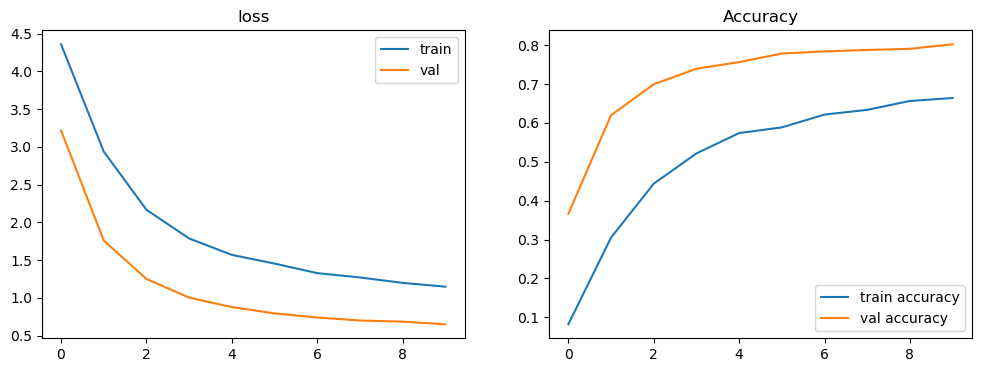

In [14]:
# Plot the loss and accuracy for MODEL 1
plot_history(history_1, title="Model 1")

In [16]:
# Evaluate MODEL 1 on the test dataset
res_model_1 = model_1.evaluate(test_ds_prepro)
test_accuracy_model_1 = res_model_1[-1]
print(f"test_accuracy_model_1 = {round(test_accuracy_model_1,2)*100} %")
print(f'Chance level: {1./120*100:.1f}%')

269/269 [==============================] - 36s 132ms/step - loss: 0.6541 - accuracy: 0.8062
test_accuracy_model_1 = 81.0 %
Chance level: 0.8%


# MODEL 2 

In [30]:
# 2 dense layers
model_2 = Sequential([
    layers.Input((224, 224, 3)),
    layers.RandomFlip(mode='horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.2,0.2),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Flatten(),                   
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(120, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(120, activation='softmax')
])


opt = optimizers.Adam(learning_rate=1e-4)
model_2.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_5 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_8 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_5 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 random_translation (RandomT  (None, 224, 224, 3)      0         
 ranslation)                                                     
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_5   (None, 2048)            

In [32]:
# Define EarlyStopping, ModelCheckpoint and ReduceLROnPlateau callbacks
MODEL = "model_2"

es = EarlyStopping(monitor='val_accuracy', 
                   mode='max', 
                   patience=1, 
                   verbose=1, 
                   restore_best_weights=True)

mcp = ModelCheckpoint("{}.h5".format(MODEL),
                      save_weights_only=True,
                      monitor='val_accuracy',
                      mode='max',
                      verbose=0,
                      save_best_only=True)

rlr = ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.1, 
                        patience=1, 
                        verbose=0)


# Train the model using the preprocessed training dataset and validate using the validation dataset
history_2 = model_2.fit(train_ds_prepro, 
                    validation_data=validation_ds_prepro, 
                    epochs=20,
                    batch_size=32,
                    callbacks=[es, mcp, rlr],
                    verbose=1)

Epoch 1/20
300/300 [==============================] - 115s 383ms/step - loss: 4.5706 - accuracy: 0.0369 - val_loss: 4.0064 - val_accuracy: 0.1796 - lr: 1.0000e-04
Epoch 2/20
300/300 [==============================] - 115s 382ms/step - loss: 4.0164 - accuracy: 0.1104 - val_loss: 3.0141 - val_accuracy: 0.3746 - lr: 1.0000e-04
Epoch 3/20
300/300 [==============================] - 116s 385ms/step - loss: 3.4169 - accuracy: 0.1857 - val_loss: 2.2168 - val_accuracy: 0.5200 - lr: 1.0000e-04
Epoch 4/20
300/300 [==============================] - 115s 382ms/step - loss: 2.9781 - accuracy: 0.2628 - val_loss: 1.7486 - val_accuracy: 0.6037 - lr: 1.0000e-04
Epoch 5/20
300/300 [==============================] - 118s 394ms/step - loss: 2.6957 - accuracy: 0.3083 - val_loss: 1.4551 - val_accuracy: 0.6542 - lr: 1.0000e-04
Epoch 6/20
300/300 [==============================] - 118s 392ms/step - loss: 2.4853 - accuracy: 0.3441 - val_loss: 1.2425 - val_accuracy: 0.6929 - lr: 1.0000e-04
Epoch 7/20
300/300 [==

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

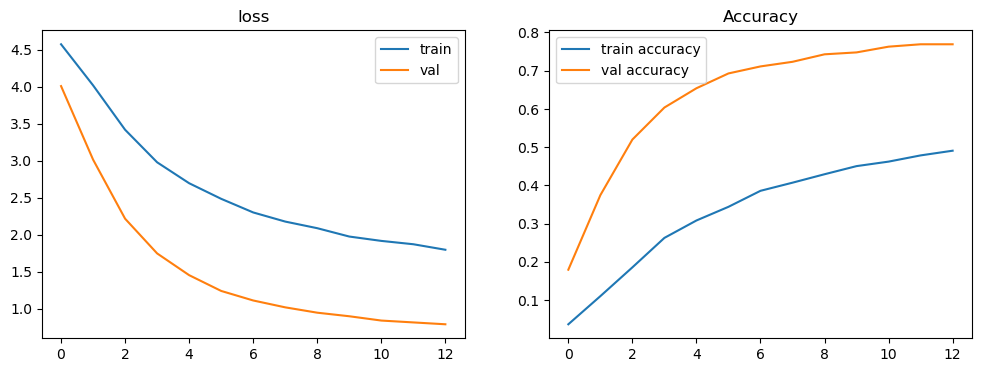

In [33]:
# Plot the loss and accuracy for MODEL 2
plot_history(history_2, title="Model 2")

In [34]:
# Evaluate MODEL 2 on the test dataset
res_model_2 = model_2.evaluate(test_ds_prepro)
test_accuracy_model_2 = res_model_2[-1]
print(f"test_accuracy_model_1 = {round(test_accuracy_model_2,2)*100} %")
print(f'Chance level: {1./120*100:.1f}%')

269/269 [==============================] - 29s 107ms/step - loss: 0.8106 - accuracy: 0.7732
test_accuracy_model_1 = 77.0 %
Chance level: 0.8%


# MODEL 3

In [35]:
model_3 = Sequential([
    layers.Input((224, 224, 3)),
    layers.RandomFlip(mode='horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.2,0.2),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Flatten(),                   
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(120, activation='softmax')
])


opt = optimizers.Adam(learning_rate=0.0005)
model_3.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model_3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_6 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_9 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_6 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 random_translation_1 (Rando  (None, 224, 224, 3)      0         
 mTranslation)                                                   
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_6   (None, 2048)            

In [36]:
# Define EarlyStopping, ModelCheckpoint and ReduceLROnPlateau callbacks
MODEL = "model_3"

es = EarlyStopping(monitor='val_accuracy', 
                   mode='max', 
                   patience=2, 
                   verbose=1, 
                   restore_best_weights=True)

mcp = ModelCheckpoint("{}.h5".format(MODEL),
                      save_weights_only=True,
                      monitor='val_accuracy',
                      mode='max',
                      verbose=0,
                      save_best_only=True)

rlr = ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.1, 
                        patience=2, 
                        verbose=0)


# Train the model using the preprocessed training dataset and validate using the validation dataset
history_3 = model_3.fit(train_ds_prepro, 
                    validation_data=validation_ds_prepro, 
                    epochs=20,
                    batch_size=32,
                    callbacks=[es, mcp, rlr],
                    verbose=1)
#0.3663

Epoch 1/20
300/300 [==============================] - 127s 396ms/step - loss: 3.4725 - accuracy: 0.2041 - val_loss: 1.3909 - val_accuracy: 0.6446 - lr: 5.0000e-04
Epoch 2/20
300/300 [==============================] - 118s 391ms/step - loss: 2.0001 - accuracy: 0.4455 - val_loss: 0.8990 - val_accuracy: 0.7279 - lr: 5.0000e-04
Epoch 3/20
300/300 [==============================] - 115s 383ms/step - loss: 1.6526 - accuracy: 0.5280 - val_loss: 0.7719 - val_accuracy: 0.7583 - lr: 5.0000e-04
Epoch 4/20
300/300 [==============================] - 119s 394ms/step - loss: 1.4856 - accuracy: 0.5682 - val_loss: 0.7076 - val_accuracy: 0.7688 - lr: 5.0000e-04
Epoch 5/20
300/300 [==============================] - 118s 391ms/step - loss: 1.3672 - accuracy: 0.5957 - val_loss: 0.6616 - val_accuracy: 0.7771 - lr: 5.0000e-04
Epoch 6/20
300/300 [==============================] - 114s 380ms/step - loss: 1.2754 - accuracy: 0.6174 - val_loss: 0.6339 - val_accuracy: 0.7883 - lr: 5.0000e-04
Epoch 7/20
300/300 [==

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

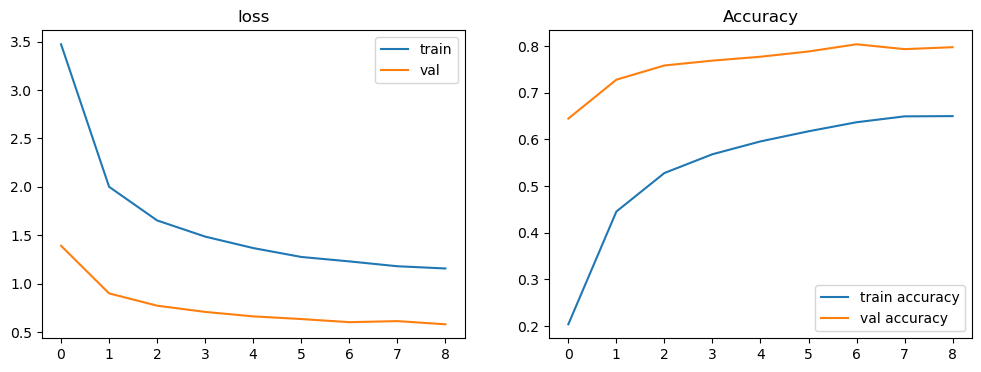

In [37]:
# Plot the loss and accuracy for MODEL 3
plot_history(history_3, title="Model 3")

In [38]:
# Evaluate MODEL 3 on the test dataset
res_model_3 = model_3.evaluate(test_ds_prepro)
test_accuracy_model_3 = res_model_3[-1]
print(f"test_accuracy_model_1 = {round(test_accuracy_model_3,2)*100} %")
print(f'Chance level: {1./120*100:.1f}%')

269/269 [==============================] - 28s 101ms/step - loss: 0.6078 - accuracy: 0.8027
test_accuracy_model_1 = 80.0 %
Chance level: 0.8%


# MODEL 4

In [13]:
model_4 = Sequential([
    layers.Input((224, 224, 3)),
    layers.RandomFlip(mode='horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.2,0.2),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Flatten(),                   
    layers.Dense(100, activation='relu'),
    layers.Dense(120, activation='softmax')
])


opt = optimizers.Adam(learning_rate=0.0005)
model_4.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                                 
 random_translation (RandomT  (None, 224, 224, 3)      0         
 ranslation)                                                     
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0

In [14]:
# Define EarlyStopping, ModelCheckpoint and ReduceLROnPlateau callbacks
MODEL = "model_4"

es = EarlyStopping(monitor='val_accuracy', 
                   mode='max', 
                   patience=5, 
                   verbose=1, 
                   restore_best_weights=True)

mcp = ModelCheckpoint("{}.h5".format(MODEL),
                      save_weights_only=True,
                      monitor='val_accuracy',
                      mode='max',
                      verbose=0,
                      save_best_only=True)

rlr = ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.1, 
                        patience=2, 
                        verbose=0)


# Train the model using the preprocessed training dataset and validate using the validation dataset
history_4 = model_4.fit(train_ds_prepro, 
                    validation_data=validation_ds_prepro, 
                    epochs=40,
                    batch_size=32,
                    callbacks=[es, mcp, rlr],
                    verbose=1)
#0.3663

Epoch 1/40
300/300 [==============================] - 142s 424ms/step - loss: 3.3515 - accuracy: 0.2364 - val_loss: 1.5282 - val_accuracy: 0.5850 - lr: 5.0000e-04
Epoch 2/40
300/300 [==============================] - 116s 386ms/step - loss: 1.7292 - accuracy: 0.5276 - val_loss: 0.9803 - val_accuracy: 0.7038 - lr: 5.0000e-04
Epoch 3/40
300/300 [==============================] - 114s 377ms/step - loss: 1.3755 - accuracy: 0.6093 - val_loss: 0.8413 - val_accuracy: 0.7267 - lr: 5.0000e-04
Epoch 4/40
300/300 [==============================] - 114s 379ms/step - loss: 1.2391 - accuracy: 0.6403 - val_loss: 0.7250 - val_accuracy: 0.7700 - lr: 5.0000e-04
Epoch 5/40
300/300 [==============================] - 112s 372ms/step - loss: 1.1132 - accuracy: 0.6665 - val_loss: 0.6914 - val_accuracy: 0.7788 - lr: 5.0000e-04
Epoch 6/40
300/300 [==============================] - 115s 383ms/step - loss: 1.0501 - accuracy: 0.6840 - val_loss: 0.6746 - val_accuracy: 0.7746 - lr: 5.0000e-04
Epoch 7/40
300/300 [==

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

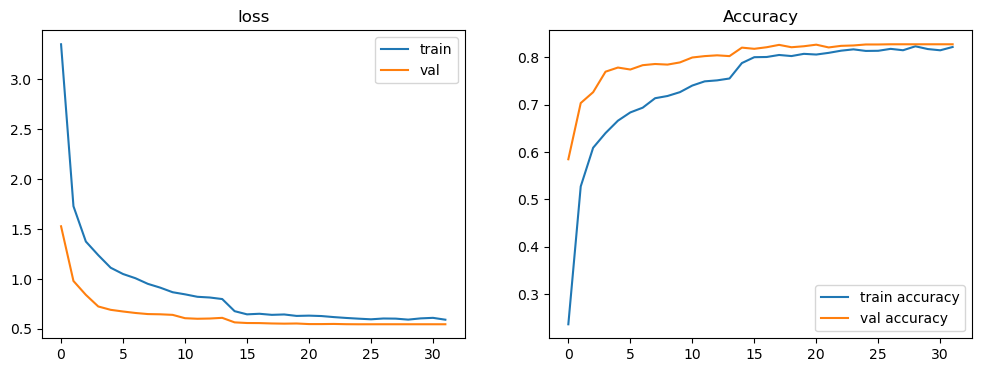

In [15]:
# Plot the loss and accuracy for MODEL 4
plot_history(history_4, title="Model 4")

In [16]:
# Evaluate MODEL 4 on the test dataset
res_model_4 = model_4.evaluate(test_ds_prepro)
test_accuracy_model_4 = res_model_4[-1]
print(f"test_accuracy_model_1 = {round(test_accuracy_model_4,2)*100} %")
print(f'Chance level: {1./120*100:.1f}%')

269/269 [==============================] - 39s 144ms/step - loss: 0.5656 - accuracy: 0.8125
test_accuracy_model_1 = 81.0 %
Chance level: 0.8%


# MODEL 5

In [43]:
model_5 = Sequential([
    layers.Input((224, 224, 3)),
    layers.RandomFlip(mode='horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.2,0.2),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Flatten(),                   
    layers.Dense(100, activation='relu'),
    layers.Dense(120, activation='softmax')
])


opt = optimizers.Adam(learning_rate=0.001)
model_5.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model_5.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_8 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_11 (RandomR  (None, 224, 224, 3)      0         
 otation)                                                        
                                                                 
 random_zoom_8 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 random_translation_3 (Rando  (None, 224, 224, 3)      0         
 mTranslation)                                                   
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_8   (None, 2048)            

In [44]:
# Define EarlyStopping, ModelCheckpoint and ReduceLROnPlateau callbacks
MODEL = "model_5"

es = EarlyStopping(monitor='val_accuracy', 
                   mode='max', 
                   patience=5, 
                   verbose=1, 
                   restore_best_weights=True)

mcp = ModelCheckpoint("{}.h5".format(MODEL),
                      save_weights_only=True,
                      monitor='val_accuracy',
                      mode='max',
                      verbose=0,
                      save_best_only=True)

rlr = ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.1, 
                        patience=2, 
                        verbose=0)


# Train the model using the preprocessed training dataset and validate using the validation dataset
history_5 = model_5.fit(train_ds_prepro, 
                    validation_data=validation_ds_prepro, 
                    epochs=40,
                    batch_size=32,
                    callbacks=[es, mcp, rlr],
                    verbose=1)
#0.3663

Epoch 1/40
300/300 [==============================] - 122s 379ms/step - loss: 2.9635 - accuracy: 0.2944 - val_loss: 1.2019 - val_accuracy: 0.6475 - lr: 0.0010
Epoch 2/40
300/300 [==============================] - 116s 387ms/step - loss: 1.5564 - accuracy: 0.5487 - val_loss: 0.8505 - val_accuracy: 0.7267 - lr: 0.0010
Epoch 3/40
300/300 [==============================] - 115s 381ms/step - loss: 1.2866 - accuracy: 0.6097 - val_loss: 0.7809 - val_accuracy: 0.7379 - lr: 0.0010
Epoch 4/40
300/300 [==============================] - 114s 379ms/step - loss: 1.1897 - accuracy: 0.6453 - val_loss: 0.7263 - val_accuracy: 0.7650 - lr: 0.0010
Epoch 5/40
300/300 [==============================] - 117s 387ms/step - loss: 1.1008 - accuracy: 0.6723 - val_loss: 0.6984 - val_accuracy: 0.7675 - lr: 0.0010
Epoch 6/40
300/300 [==============================] - 114s 378ms/step - loss: 1.0449 - accuracy: 0.6814 - val_loss: 0.6766 - val_accuracy: 0.7721 - lr: 0.0010
Epoch 7/40
300/300 [==========================

KeyboardInterrupt: 

# Visualize the the activations (the base model)

In [46]:
model_4.save("model_4.h5")

In [47]:
from tensorflow.keras.models import load_model

model_4 = load_model("model_4.h5")

In [48]:
# The first convolutional layer

model_4.summary()
model_4.layers



## Accessing the first convolutional layer of the CNN:
#first_convolutional_layer = model.layers[0]
## Weights of the first convolutional layer of the CNN - which was trained/optimized
#first_convolutional_layer.weights[0].shape   #TensorShape([4, 4, 1, 16])   #the weights of each kernel (size 4×4) + 1 channel (single B&W input) + we chose 16 different kernels in this layer!
# # Biases of the first convolutional layer of the CNN - which was trained/optimized
# first_convolutional_layer.weights[1].shape  #TensorShape([16])   #>>>4*4*1*16+16 = 256 weights + 16 biases = 272 parameters for the first convolutional layer

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_7 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_10 (RandomR  (None, 224, 224, 3)      0         
 otation)                                                        
                                                                 
 random_zoom_7 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 random_translation_2 (Rando  (None, 224, 224, 3)      0         
 mTranslation)                                                   
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_7   (None, 2048)            

In [96]:
def compute_convolution(input_image, kernel):
    # Parameters
    kernel = np.array(kernel)
    kernel_height, kernel_width = kernel.shape

    img = np.squeeze(input_image) # Removes dimensions of size 1     #shape: (224, 224, 3)
    img_height, img_width, color_layers  = img.shape
    
    output_image = []

    for x in range(img_height - kernel_height + 1):
        arr = []
        
        for y in range(img_width - kernel_width + 1):
            
            a = np.multiply(img[x: x + kernel_height, y: y + kernel_width],
                            kernel)
            arr.append(a.sum())
            
        output_image.append(arr)
        
    return output_image

In [57]:
def plot_convolution(img, kernel, activation=False):
    ''' The following printing function ease the visualization'''
    
    img = np.squeeze(img)
    output_img = compute_convolution(img, kernel)
    if activation:
        output_img = np.maximum(output_img, 0)
    
    plt.figure(figsize=(10, 5))
    
    ax1 = plt.subplot2grid((3,3),(0,0), rowspan=3)
    ax1.imshow(img, cmap=None)
    ax1.title.set_text('Input image')
    
    ax2 = plt.subplot2grid((3,3),(1, 1))
    ax2.imshow(kernel, cmap=None)
    ax2.title.set_text('Kernel')    
    
    ax3 = plt.subplot2grid((3,3),(0, 2), rowspan=3)
    ax3.imshow(output_img, cmap=None)
    ax3.title.set_text('Output image')    

    for ax in [ax1, ax2, ax3]:
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        
    plt.show()

In [49]:
base_model.summary()
base_model.layers

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [52]:
first_convolutional_layer = base_model.layers[2]
first_convolutional_layer 

In [64]:
base_model.layers[2].weights[0].numpy()[:, :, 0, 1]

array([[-0.01187372, -0.00720698, -0.01060733, -0.00882987, -0.00860503,
        -0.00407941, -0.01125184],
       [-0.00949061, -0.00957964, -0.01196501, -0.01686904, -0.01064576,
        -0.00869292, -0.0102823 ],
       [-0.01596291, -0.01235135, -0.01760809, -0.0201157 , -0.01674864,
        -0.00851824, -0.011774  ],
       [-0.01316791, -0.01232569, -0.01221589, -0.01420524, -0.01532342,
        -0.01200634, -0.0131315 ],
       [-0.01627185, -0.01346532, -0.01796557, -0.01258958, -0.01075901,
        -0.00909058, -0.01270145],
       [-0.00830464, -0.00477699, -0.01222234, -0.0089184 , -0.00981472,
        -0.00422911, -0.01088459],
       [-0.00915219, -0.00327857, -0.00466613, -0.00250248, -0.00316392,
         0.00220948, -0.00422943]], dtype=float32)

In [90]:
first_image_train.shape

TensorShape([224, 224, 3])

In [124]:
first_image_train.shape
a = first_image_train
a.shape
# img_height, img_width = a[0:2]
# img_height
# img_width

TensorShape([224, 224, 3])

In [130]:
np.array(a).resize(((224,224)))

In [95]:
img_height, img_width, color_layers  = a.shape
print(img_height)
print(img_width)

224
224


In [98]:
kernel = base_model.layers[2].weights[0].numpy()[:, :, 0, 0]
kernel.shape
kernel_height, kernel_width = kernel.shape
kernel_height

7

In [100]:
print(img_height - kernel_height + 1)
print(img_width - kernel_width + 1)

218
218


In [112]:
b = a[1: 1 + kernel_height, 1: 1 + kernel_width]
b.shape

(7, 7, 3)

In [97]:
compute_convolution(first_image_train, kernel)

ValueError: operands could not be broadcast together with shapes (7,7,3) (7,7) 

In [76]:
kernel = base_model.layers[2].weights[0].numpy()[:, :, 0, 0]

plot_convolution(first_image_train, kernel, activation=True)

ValueError: too many values to unpack (expected 2)

In [ ]:
def compute_convolution(input_image, kernel):
    # Parameters
    kernel = np.array(kernel)
    kernel_height, kernel_width = kernel.shape

    img = np.squeeze(input_image) # Removes dimensions of size 1     #shape: (224, 224, 3)
    img_height, img_width, color_layers  = img.shape
    
    output_image = []

    for x in range(img_height - kernel_height + 1):
        arr = []
        
        for y in range(img_width - kernel_width + 1):
            
            a = np.multiply(img[x: x + kernel_height, y: y + kernel_width],
                            kernel)
            arr.append(a.sum())
            
        output_image.append(arr)
        
    return output_image